In [1]:
import itertools as itt
import biomappings
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
positive_mappings = biomappings.load_mappings()
print(f"There are {len(positive_mappings):,} positive mappings")

There are 8,678 positive mappings


In [3]:
negative_mappings = biomappings.load_false_mappings()
print(f"There are {len(negative_mappings):,} negative mappings")

There are 1,182 negative mappings


In [4]:
predicted_mappings = biomappings.load_predictions()
print(f"There are {len(predicted_mappings):,} predicted mappings")

There are 40,987 predicted mappings


In [5]:
def source_target_counter(mappings) -> Counter:
    return Counter(
        tuple(sorted((mapping["source prefix"], mapping["target prefix"])))
        for mapping in mappings
    )

In [6]:
keyed_mappings = [
    ("positive", positive_mappings), 
    ("negative", negative_mappings),
    ('predicted', predicted_mappings),
]

# Biased Measurement of Precision

There are two kinds of mappings we'll consider:

1. Manually curated positive (i.e., correct) mappings. These correspond to true positives.
2. Manually curated negative (i.e., incorrect) mappings. These correspond to false positives.

Most of these mappings originated as predictions from Gilda, with an additional small number being input by curators directly (which is small enough that we'll disregard).

Unfortunately, it's hard to accurately count false negatives and true negatives as the space of potential negative mappings is massive, and also can be defined in several ways, such as if you make the assumption that mappings must be one-to-one and not one-to-many, many-to-one, or many-to-many.

## Caveats

The metrics reported in this section are **heavily biased** due to non-random ways curation was done:

1. Curation was done based on task-based need, meaning that certain resources were included and others were excluded
2. Curation was prioritized based on confidence in order to maximize positive mapping throughput with respect to curator effort

In [7]:
tp = len(positive_mappings)
fp = len(negative_mappings)

precision = tp / (tp + fp)


print(f"The overall unweighed precision is {precision:.2%}.")

The overall unweighed precision is 88.01%.


## Precision by Source

Because mappings are first predicted on the basis of source, the overall precision can be split based on the source prefix of each mapping.

In [8]:
pairs = {
    key: Counter(
        mapping["source prefix"]
        for mapping in mappings
    )
    for key, mappings in keyed_mappings
}
df1 = pd.DataFrame(pairs).fillna(0).astype(int)
df1.index.name = "source"
df1 = df1[df1["positive"] + df1["negative"] > 20]
df1["precision"] = (df1["positive"] / (df1["positive"] + df1["negative"])).round(2)
df1["biased"] = df1["predicted"] != 0
# df["fdr"] = df["negative"] / (df["positive"] + df["negative"])
df1.sort_values("precision", inplace=True, ascending=False)

df1

,positive,negative,predicted,precision,biased
source,,,,,
uniprot.chain,27,0,0,1.00,False
chebi,1617,13,9848,0.99,True
uberon,131,3,68,0.98,True
mondo,207,7,78,0.97,True
mesh,4322,324,26891,0.93,True
ccle,690,70,0,0.91,False
pr,80,9,0,0.90,False
wikipathways,467,60,1685,0.89,True
agrovoc,142,20,0,0.88,False


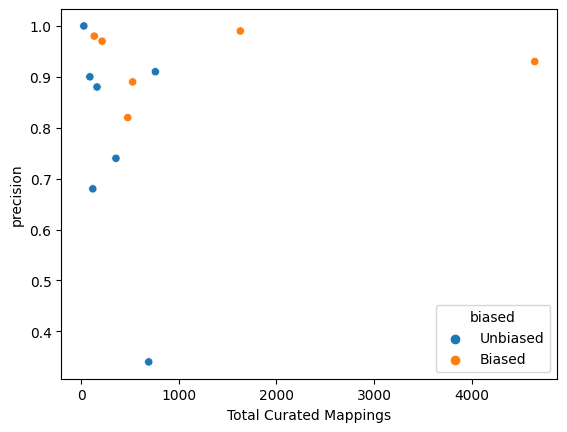

In [9]:
ax = sns.scatterplot(
    x=df1["positive"] + df1["negative"],
    y=df1["precision"],
    hue=df1["biased"].map(lambda b: "Biased" if b else "Unbiased")
)
ax.set_xlabel("Total Curated Mappings")
plt.show()

A more granular view is calculated by stratifying by both the source and target prefix of the mappings.

In [10]:
pairs = {
    key: source_target_counter(mappings)
    for key, mappings in keyed_mappings
}
df2 = pd.DataFrame(pairs).fillna(0).astype(int)
df2.index.set_names(["source", "target"], inplace=True)
df2 = df2[df2["positive"] + df2["negative"] > 20]
df2["precision"] = (df2["positive"] / (df2["positive"] + df2["negative"])).round(2)
df2["biased"] = df2["predicted"] != 0

# if there are no predictions, then we know that
# the false negative is zero.
# trivially: sensitivity=1,
# We can also calculate metrics that use that as well
# TP, FP, FN

df2.sort_values("precision", inplace=True, ascending=False)
df2

positive  negative  predicted  precision  biased
source       target                                                         
mesh         uniprot             378         0      10970       1.00    True
go           wikipathways        366         0          0       1.00   False
ncbiprotein  uniprot.chain        26         0          0       1.00   False
kegg.pathway wikipathways         70         0          0       1.00   False
             reactome             61         0          0       1.00   False
chebi        mesh               2698        23      12061       0.99    True
reactome     wikipathways         73         1          0       0.99   False
mesh         ncit                888        14      11751       0.98    True
ccle         efo                 570        10          0       0.98   False
mesh         uberon              131         3         68       0.98    True
             mondo               207         7         78       0.97    True
doid         efo                  63         7         72       0.90    True
pr           uniprot.chain        81         9          0       0.90   False
agro         agrovoc             142        20          0       0.88   False
go           kegg.pathway        113        16          0       0.88   False
doid         mesh               1455       198         58       0.88    True
             umls                187        35       2345       0.84    True
hgnc         mesh                102        21       1368       0.83    True
efo          mesh                108        25        166       0.81    True
go           mesh                425        99         13       0.81    True
             reactome            222        91          0       0.71   False
cl           mesh                 81        38          0       0.68   False
ccle         cellosaurus         114        59          0       0.66   False
mesh         wikipathways         18        45          0       0.29   False
kegg.pathway mesh                 25        77          0       0.25   False
mesh         reactome              8       218          0       0.04   False
fplx         reactome              0        49          0       0.00   False
chebi        reactome              0        85          0       0.00   False

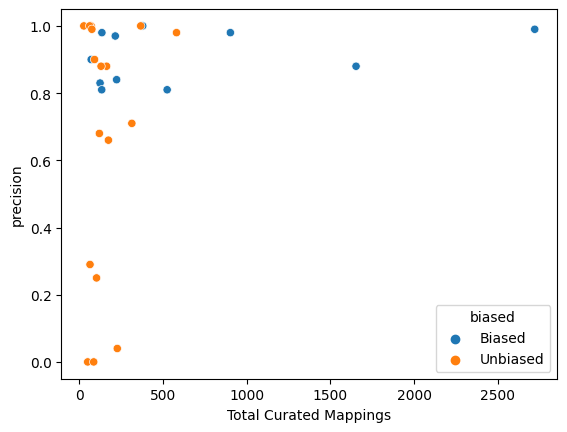

In [11]:
ax = sns.scatterplot(
    x=df2["positive"] + df2["negative"],
    y=df2["precision"],
    hue=df2["biased"].map(lambda b: "Biased" if b else "Unbiased"),
)
ax.set_xlabel("Total Curated Mappings")
plt.show()

# Remaining Curation Effort

In [12]:
pd.DataFrame(
    [(s,t,c)
    for (s,t), c in reversed(source_target_counter(predicted_mappings).most_common())
    ],
    columns=["source", "target", "count"]
)

,source,target,count
0,go,mesh,13
1,doid,mesh,58
2,mesh,uberon,68
3,doid,efo,72
4,mesh,mondo,78
5,efo,mesh,166
6,hp,mesh,352
7,hgnc,mesh,1368
8,wikipathways,wikipathways,1685
9,doid,umls,2345
